In [12]:
# Author: Remi Flamary <remi.flamary@unice.fr>
#
# License: MIT License

import numpy as np
import matplotlib.pylab as pl
#%pylab osx
#%matplotlib osx
import ot
# necessary for 3d plot even if not used
from mpl_toolkits.mplot3d import Axes3D  # noqa
from matplotlib.collections import PolyCollection

In [32]:
#%% parameters

n = 100  # nb bins

# bin positions
x = np.arange(n, dtype=np.float64)

# Gaussian distributions
#a1 = ot.datasets.get_1D_gauss(n, m=20, s=5)  # m= mean, s= std
#a2 = ot.datasets.get_1D_gauss(n, m=60, s=8)

# creating matrix A containing all distributions
#A = np.vstack((a1, a2)).T

A = np.zeros((n, 10))
A[10,0] = 1
A[12,1] = 1
A[15,2] = 1
A[15,3] = 1
A[6,4] = 1
A[14,5] = 1
A[13,6] = 1
A[14,7] = 1
A[15,8] = 1
A[55,9] = 1
A[A>0] = 0.95
A[A==0] = 0.05/(n-1)
n_distributions = A.shape[1]

# loss matrix + normalization
M = ot.utils.dist0(n)
M /= M.max()

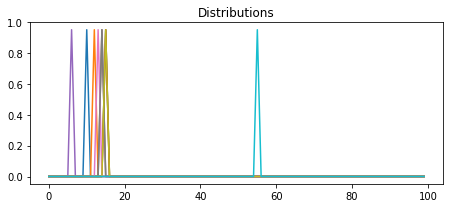

In [33]:
#%% plot the distributions

pl.figure(1, figsize=(6.4, 3))
for i in range(n_distributions):
    pl.plot(x, A[:, i])
pl.title('Distributions')
pl.tight_layout()

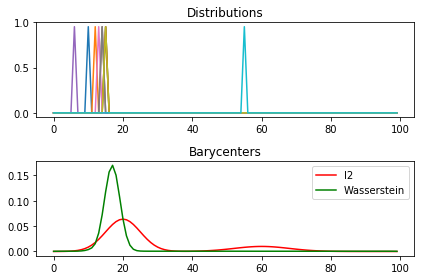

In [34]:
#%% barycenter computation

#alpha = 0.2  # 0<=alpha<=1
#weights = np.array([1 - alpha, alpha])

# l2bary
#bary_l2 = A.dot(weights)

# wasserstein
reg = 1e-3
bary_wass = ot.bregman.barycenter(A, M, reg)#, weights)

pl.figure(2)
pl.clf()
pl.subplot(2, 1, 1)
for i in range(n_distributions):
    pl.plot(x, A[:, i])
pl.title('Distributions')

pl.subplot(2, 1, 2)
pl.plot(x, bary_l2, 'r', label='l2')
pl.plot(x, bary_wass, 'g', label='Wasserstein')
pl.legend()
pl.title('Barycenters')
pl.tight_layout()

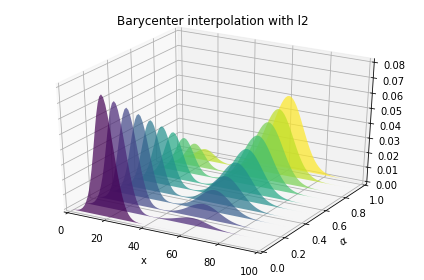

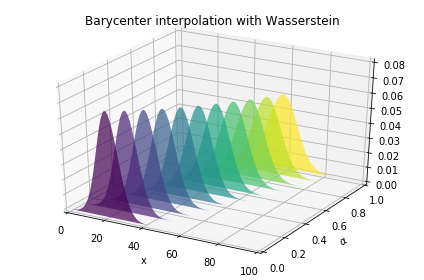

In [5]:
#%% barycenter interpolation

n_alpha = 11
alpha_list = np.linspace(0, 1, n_alpha)


B_l2 = np.zeros((n, n_alpha))

B_wass = np.copy(B_l2)

for i in range(0, n_alpha):
    alpha = alpha_list[i]
    weights = np.array([1 - alpha, alpha])
    B_l2[:, i] = A.dot(weights)
    B_wass[:, i] = ot.bregman.barycenter(A, M, reg, weights)

#%% plot interpolation

pl.figure(3)

cmap = pl.cm.get_cmap('viridis')
verts = []
zs = alpha_list
for i, z in enumerate(zs):
    ys = B_l2[:, i]
    verts.append(list(zip(x, ys)))

ax = pl.gcf().gca(projection='3d')

poly = PolyCollection(verts, facecolors=[cmap(a) for a in alpha_list])
poly.set_alpha(0.7)
ax.add_collection3d(poly, zs=zs, zdir='y')
ax.set_xlabel('x')
ax.set_xlim3d(0, n)
ax.set_ylabel('$\\alpha$')
ax.set_ylim3d(0, 1)
ax.set_zlabel('')
ax.set_zlim3d(0, B_l2.max() * 1.01)
pl.title('Barycenter interpolation with l2')
pl.tight_layout()

pl.figure(4)
cmap = pl.cm.get_cmap('viridis')
verts = []
zs = alpha_list
for i, z in enumerate(zs):
    ys = B_wass[:, i]
    verts.append(list(zip(x, ys)))

ax = pl.gcf().gca(projection='3d')

poly = PolyCollection(verts, facecolors=[cmap(a) for a in alpha_list])
poly.set_alpha(0.7)
ax.add_collection3d(poly, zs=zs, zdir='y')
ax.set_xlabel('x')
ax.set_xlim3d(0, n)
ax.set_ylabel('$\\alpha$')
ax.set_ylim3d(0, 1)
ax.set_zlabel('')
ax.set_zlim3d(0, B_l2.max() * 1.01)
pl.title('Barycenter interpolation with Wasserstein')
pl.tight_layout()

pl.show()

In [8]:
print(n)
M=ot.utils.dist0(n)
M.shape

100


(100, 100)

In [10]:
A.shape

(100, 2)

In [14]:
n_test = 10
A_test = np.matrix([[0,1,2,3,4,5,6,7,8,9],[0,1,2,3,4,5,6,7,8,9]])
M_test = ot.utils.dist0(n_test)
print(M_test.shape)
reg = 1e-3
bary_wass = ot.bregman.barycenter(A_test, M_test, reg)

(10, 10)


/Users/omarchavez/anaconda2/lib/python2.7/site-packages/ot/bregman.py:801: RuntimeWarning: divide by zero encountered in log
  return np.exp(np.mean(np.log(alldistribT), axis=1))


ValueError: operands could not be broadcast together with shapes (10,1) (2,10) 

In [1]:
import numpy as np

import particle_filter
import simulate_data
import embarrassingly_parallel
import pf_plots 

M=4
PART_NUM=1000
epoch_at=[99,199,299,399]
params={'N': 100*M, 
        'N_batch':1, 
        'omega_shift' : [0,3], 
        'shards': M,
        'epoch_at':epoch_at,
        'particles_per_shard':PART_NUM,
        'model':'probit_sin_wave',
        'sample_method':"importance"}

test, params = simulate_data.temp_make_data_function(params, model='probit_sin_wave', show=True)

cmcobj=embarrassingly_parallel.embarrassingly_parallel(test['epoch_data']['epoch0'], params)
cmcobj.shuffel_embarrassingly_parallel_particles(method="wasserstein", wass_n=10)
for ea in range(1,len(test['epoch_data'].keys())-1):
    print(ea)
    cmcobj.run_batch(test['epoch_data']['epoch'+str(ea)])
    cmcobj.shuffel_embarrassingly_parallel_particles(method="wasserstein", wass_n=10)

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

('sig=', 6.917854385822338e-05)
parallel class...
('fitting shard ', 0)
('working on model ', 'probit_sin_wave')
('fitting shard ', 1)
('working on model ', 'probit_sin_wave')
('fitting shard ', 2)
('working on model ', 'probit_sin_wave')
('fitting shard ', 3)
('working on model ', 'probit_sin_wave')
computing waserstein barrycenter...
collecting parameter info from shards...
data successfully prepared...
('machine weights: ', array([0.385, 0.115, 0.375, 0.125]))
1
computing waserstein barrycenter...
collecting parameter info from shards...
data successfully prepared...
('machine weights: ', array([0.24 , 0.225, 0.3  , 0.235]))
2
computing waserstein barrycenter...
collecting parameter info from shards...
data successfully prepared...
('machine weights: ', array([0.17   , 0.48125, 0.28625, 0.0625 ]))
3
computing waserstein barrycenter...
collecting parameter info from shards...
data successfully prepared...
('machine weights: ', array([0.215, 0.19 , 0.475, 0.12 ]))


plot_parameter_path...


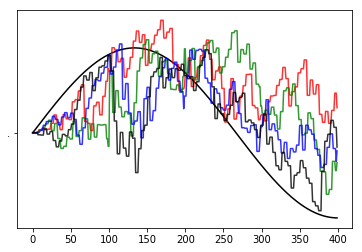

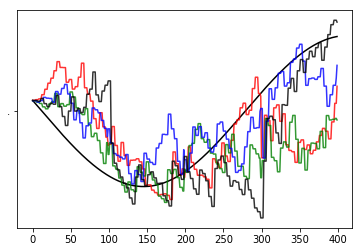

In [3]:
cmcobj.plot_CMC_parameter_path_by_shard(.999)

In [4]:
from scipy.optimize import linprog
from random import randint

d=len(params['omega_shift'])
K = params['shards']
n=10

def plot_selected_particles(myTheta_f, f_K, f_alpha):
    colors = ['red','green','blue','black']
    lmT=len(myTheta_f)
    f_n=len(myTheta_f[0][0][:,0])
    size=np.sum(f_alpha, axis=0)/np.sum(np.sum(f_alpha, axis=0))
         #np.sum(f_alpha, axis=0)/np.sum(np.sum(f_alpha, axis=0))
    #print(size)
    #alpha_rep=np.repeat(alpha, f_n)
    for mT in range(lmT):
        for j in range(f_K):
            alf=f_alpha[mT][j]*0.99/(np.max(f_alpha[mT])-np.min(f_alpha[mT]))
            plt.plot(myTheta_f[mT][j][:,0], 
                     myTheta_f[mT][j][:,1], 'x', 
                     color=colors[j], 
                     alpha=alf)#+(1-np.max(f_alpha[mT])/2))
    plt.legend((range(f_K)), loc='upper right')
    plt.show()  
    
    for mT in range(lmT):
        for j in range(f_K):
        #print('***********')
        #print(size[j])
            plt.scatter(myTheta_f[mT][j][:,0], 
                     myTheta_f[mT][j][:,1],
                     color='b', s=size[j]*size[j]*100, alpha=.5)#+(1-np.max(f_alpha[mT])/2))
    #plt.legend((range(f_K)), loc='upper right')
    plt.show()  
    
def prep_particles_for_wassber(cmcobj, n):
#if True:
    #print("running the code to make theta")
    #n=PART_NUM
    K=params['shards']
    
    myTheta=list()
    theta = np.zeros((n*K,len(params['omega_shift'])))
    row=0
    for m in range(params['shards']):
        myTheta.append(np.zeros((n,len(params['omega_shift']))))
        for p in range(n):
            particle_index = randint(0, PART_NUM-1)
            theta[row,:] = myTheta[m][p,:] = cmcobj.pf_obj[m].particle_list[particle_index].bo
            row+=1
    return theta, myTheta
# base vectors, matrices used in constructing constraints  
#theta = theta + [[.1,.2],[0,0],[.2,.3],[.11,.22]]

In [5]:
def get_wasserstein_barycenter(n, K, d, params, theta, myTheta):
    
    Nk1 = np.ones((1,n))    # one vector of length n
    N1  = np.ones((K*n,1))  # one vector of length K*n
    IN  = np.identity(K*n)  # Diagonal matrix of size K*n
    INk = np.identity(n)    # Diagonal matrix of size n
    
    # cost vector
    
    # each thetak is the matrix of samples from subset posterior k=1,...,K
    # theta is the overall sample matrix, formed by stacking the thetak
    #cost = c()
    cost = np.array([])
    #for (i in 1:K){
    for i in range(K):
        #thetak = myTheta[[i]]
        thetak = myTheta[i]
        #Mk = diag(theta%*%t(theta)) %*% t(Nk1) + N1 %*% t(diag(thetak%*%t(thetak)))-2*(theta%*%t(thetak))
        theta_theta_transpose = np.matmul(theta, np.transpose(theta))
        diag_of_theta_theta_transpose=np.diag(theta_theta_transpose)
        diag_of_theta_theta_transpose=diag_of_theta_theta_transpose.reshape((len(diag_of_theta_theta_transpose),1))
        sec1 = np.matmul(diag_of_theta_theta_transpose, Nk1)
        
        thetak_thetak_transpose=np.matmul(thetak, np.transpose(thetak))
        tdiag_thetak_thetak_transpose=np.transpose(np.diag(thetak_thetak_transpose))
        tdiag_thetak_thetak_transpose=tdiag_thetak_thetak_transpose.reshape((1,len(tdiag_thetak_thetak_transpose)))
        sec2 = np.matmul(N1, tdiag_thetak_thetak_transpose)
        
        theta_thetak_transpose = np.matmul(theta, np.transpose(thetak))
        sec3=-2.0*theta_thetak_transpose
        Mk = sec1 + sec2 + sec3
        #print(Mk)
        #cost = c(cost,Mk)
        cost = np.concatenate((cost, np.transpose(Mk).reshape(1,Mk.size)[0]))
    #}
    #cost = c(cost,rep(0,K*n))
    cost = np.concatenate((cost, np.zeros(K*n)))
    
    # constraint matrix 
    # A1-A6 are the 6 components of the A constraint matrix in the first Srivastava paper.
    #A1 = Matrix(rep(0,(K*n)^2),nrow=1,sparse=TRUE)
    A1 = np.zeros((1,(K*n)**2)) 
    #A2 = Matrix(rep(1,(K*n)),nrow=1,sparse=TRUE)
    A2 = np.ones((1, K*n))
    #a3 = t(Nk1)%x%IN
    a3=np.kron(Nk1, IN)
    #A3 = kronecker(Diagonal(K),a3)
    A3 = np.kron(np.identity(K), a3)
    #A4 = rep(1,K)%x%IN
    A4 = np.kron(np.ones((K,1)), IN)
    #a5 = INk%x%t(N1)
    a5 = np.transpose(np.kron(INk, N1))
    #A5 = kronecker(Diagonal(K),a5)
    A5 = np.transpose(np.kron(np.identity(K), np.transpose(a5)))
    #A6 = matrix(rep(0,(K*n)^2),nrow=K*n)
    A6 = np.zeros((K*n, K*n))
    #A = rBind(cBind(A1,A2),cBind(A3,-A4),cBind(A5,A6)) # column and row stack matrices into overall constraints
    cbA1A2  = np.concatenate((A1, A2), axis=1)
    cbA3mA4 = np.concatenate((A3, -A4), axis=1)
    cbA5A6  = np.concatenate((A5, A6), axis=1)
    A = np.concatenate((cbA1A2, cbA3mA4, cbA5A6)) 

    # the right hand side of constraints for the matrix A
    #consRHS = c(1,rep(0,(K^2)*n),rep((1/100),K*n))
    consRHS = np.concatenate((np.ones(1), 
                              np.zeros((K**2)*n), 
                              1.0/n*np.ones(K*n)))
    
    # direction of the constraints.
    #consDIR = c(rep("==",(K^2+K)*n+1))
    
    # note the constraint that the output vector 'a' of probabilities is >=0 is not explicitly put into the solver
    # since this solver already inputs this constraint, other solver packages MAY REQUIRE THIS EXPLICITLY
    
    #out = Rglpk_solve_LP(cost,A,consDIR,consRHS,types=NULL,bounds=NULL,verbose=TRUE)
    #print("about to linprog")
    out = linprog(cost, A_eq=A, b_eq=consRHS, options={"disp": False})
    # this just extracts the relevant output containing the posterior vector of probabilities 'a' for the consensus posterior
    #end = length(out$solution)
    end = len(out['x'])
    #start = length(out$solution)-(K*n)+1
    start = len(out['x'])-K*n
    sol = out['x'][start:end]
    
    return sol

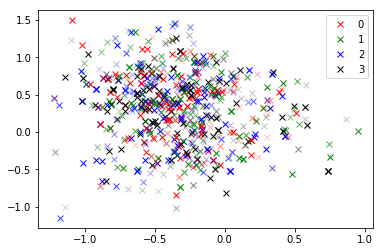

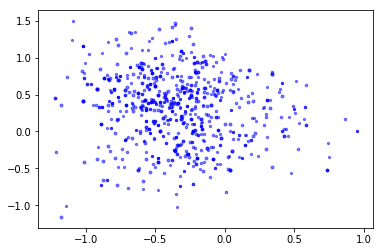

In [7]:
from matplotlib import pyplot as plt

def get_approx_shard_wasserstein_barycenter(cmcobj, params, f_n, f_K, f_d):
    wsbc_num       = 20
    wssber_wts     = {}
    theta_list     = list()
    myTheta_list   = list()
    apx_bc_mac_wts = list()
    
    for i in range(wsbc_num):
        theta, myTheta = prep_particles_for_wassber(cmcobj, f_n)
        wssber_wts[i] = get_wasserstein_barycenter(f_n, f_K, f_d, params, theta, myTheta)
        temp_wts=np.sum(np.array_split(wssber_wts[i], params['shards']), axis=1)
        apx_bc_mac_wts.append(temp_wts)
        theta_list.append(theta)
        myTheta_list.append(myTheta)
    
    f_shard_wts_0 = np.array(apx_bc_mac_wts).reshape((wsbc_num,f_K))
    f_shard_wts   = np.mean(f_shard_wts_0, axis=0)
    return f_shard_wts, apx_bc_mac_wts, theta_list, myTheta_list


shard_weights, apx_bc_mac_wts, theta_list, myTheta_list = get_approx_shard_wasserstein_barycenter(cmcobj, params, n, K, d)
plot_selected_particles(myTheta_list, K, apx_bc_mac_wts)

In [15]:
temp = np.array(apx_bc_mac_wts).reshape((20,K))
print(np.mean(temp, axis=0))
print(np.std(temp, axis=0))

In [16]:
shard_weights

array([0.39, 0.13, 0.16, 0.32])

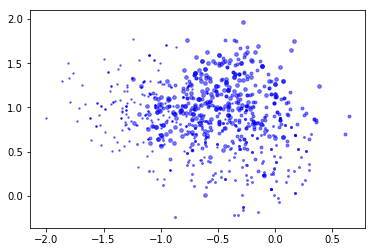

In [156]:
myTheta_f=myTheta_list
lmT=len(myTheta_f)
f_n=len(myTheta_f[0][0])
size=np.sum(apx_bc_mac_wts, axis=0)/np.sum(np.sum(apx_bc_mac_wts, axis=0))
f_K=K 
for mT in range(lmT):
    for j in range(f_K):
        #print('***********')
        #print(size[j])
        plt.scatter(myTheta_f[mT][j][:,0], 
                     myTheta_f[mT][j][:,1],
                     color='b', s=size[j]*size[j]*100, alpha=.5)#+(1-np.max(f_alpha[mT])/2))
    #plt.legend((range(f_K)), loc='upper right')
plt.show()  

In [141]:
np.repeat([size[j]],f_n)

array([0.145, 0.145, 0.145, 0.145, 0.145, 0.145, 0.145, 0.145, 0.145,
       0.145])

In [148]:
size[0]

0.1450000000000002

In [143]:
all_mac_part_wts = np.repeat(apx_bc_mac_wts, params['particles_per_shard'])
all_mac_part_wts = all_mac_part_wts/np.sum(all_mac_part_wts)
all_mac_part_wts
all_parts_index = np.random.choice(len(all_mac_part_wts), len(all_mac_part_wts), p=all_mac_part_wts)

In [66]:


np.repeat([1,2,3],2)

array([1, 1, 2, 2, 3, 3])

In [6]:
np.random.choice([1,2,3,4,5], 2)

array([4, 1])

In [148]:
particle_values = {}

for j in range(4):
    particle_values[j] = np.array([cmcobj.pf_obj[j].particle_list[i].bo for i in range(1000)])

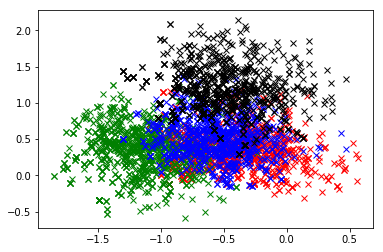

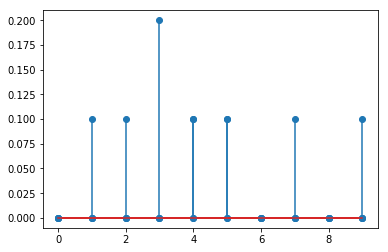

In [154]:
colors = ['red','green','blue','black']

for j in range(4):
    plt.plot(particle_values[j][:,0], particle_values[j][:,1], 'x', color=colors[j])
plt.show()

import matplotlib.pyplot as plt
for i in range(4):
    markerline, stemlines, baseline =plt.stem(wssber_wts[i*10:(i+1)*10])#, color=colors[i])
    #plt.setp(baseline, color=colors[i], linewidth=2)

plt.show()